In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim
# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_histogram, plot_rl_kl, plot_latent_space, plot_gallery

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [73]:
batch_size = 128
optimizer = torch.optim.Adam
num_normal_plots = 2

In [106]:
dataset = "LFW"

if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 2
    learning_rate = 1e-3
    h = 28
    w = 28
    img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 2 # 1000 is suggested in the paper "Tutorial on VAE" but Kingma, Welling show 20 is sufficient for MNIST
elif dataset == "LFW":
    epochs = 100
    learning_rate = 1e-2 # 1e-2 works well
    h = 50
    w = 37
    input_dim = np.prod((h, w))
    hidden_dim = 200 # as in Kingma for Frey Face, but we could maybe use 250 or 300 because we have more samples?
    z_dim = 100

In [107]:
encoder = Encoder(input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, input_dim)
model = Vae(encoder, decoder)

In [ ]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, (h, w), epochs, num_normal_plots, batch_size, learning_rate)
solver.run()

Total dataset size:
n_samples: 13233
n_features: 1850
n_classes: 5749
img dims x: 50 y: 37
+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 1702.1687
====> Test set loss avg: 1261.3492
7.330106019973755 seconds for epoch 1
====> Epoch: 2 train set loss avg: 1256.1728
====> Test set loss avg: 1255.5037
7.47987961769104 seconds for epoch 2
====> Epoch: 3 train set loss avg: 1252.7978
====> Test set loss avg: 1251.6837
7.3402485847473145 seconds for epoch 3
====> Epoch: 4 train set loss avg: 1249.7096
====> Test set loss avg: 1249.8655
7.872262477874756 seconds for epoch 4
====> Epoch: 5 train set loss avg: 1246.4039
====> Test set loss avg: 1247.3204
8.7007315158844 seconds for epoch 5
====> Epoch: 6 train set loss avg: 1240.5640
====> Test set loss avg: 1244.7440
8.33579134941101 seconds for epoch 6
====> Epoch: 7 train set loss avg: 1234.9215
====> Test set loss avg: 1244.1015
7.796199083328247 seconds for epoch 7
====> Epoch: 8 train set loss avg: 1230.1750
====> Test set loss

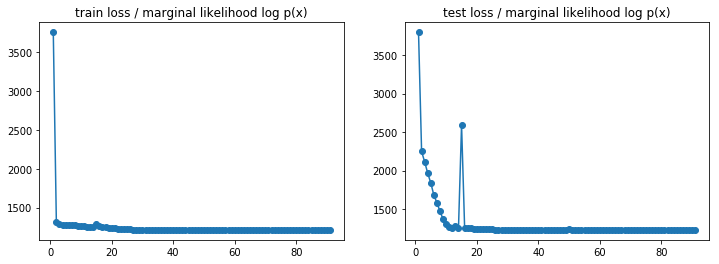

In [97]:
# Plotting train and test losses for all epochs
train_loss_history = list(list(zip(*solver.train_loss_history))[1])
plot_losses(train_loss_history, solver.test_loss_history)

In [99]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
plot_histogram(num_normal_plots, solver.z_stats, z_dim)

test 0


epoch: 1, train_loss: 186.95446, test_loss: 182.49335, recon. loss: 181.52817, KL div.: 5.42626
overfitting: 4.46112
epoch: 2, train_loss: 166.15693, test_loss: 182.44394, recon. loss: 160.90141, KL div.: 5.25562
overfitting: 16.28700
epoch: 3, train_loss: 162.98770, test_loss: 179.71562, recon. loss: 157.66234, KL div.: 5.32538
overfitting: 16.72792
epoch: 4, train_loss: 160.53854, test_loss: 180.96696, recon. loss: 155.10747, KL div.: 5.43108
overfitting: 20.42842
epoch: 5, train_loss: 158.67805, test_loss: 178.67710, recon. loss: 153.12642, KL div.: 5.55165
overfitting: 19.99905
epoch: 6, train_loss: 157.37680, test_loss: 176.73936, recon. loss: 151.74538, KL div.: 5.63141
overfitting: 19.36256
epoch: 7, train_loss: 156.31571, test_loss: 178.87962, recon. loss: 150.63150, KL div.: 5.68415
overfitting: 22.56391
epoch: 8, train_loss: 155.35629, test_loss: 177.87471, recon. loss: 149.61618, KL div.: 5.74013
overfitting: 22.51842
epoch: 9, train_loss: 154.61224, test_loss: 177.77503, re

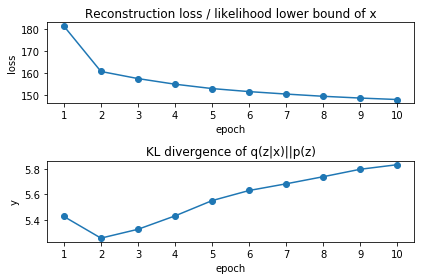

In [33]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
rls = list(list(zip(*solver.train_loss_history))[2])
kls = list(list(zip(*solver.train_loss_history))[3])
for ((epoch, train_loss, rl, kl), test_loss) in zip(solver.train_loss_history, solver.test_loss_history):
    print("epoch: {}, train_loss: {:.5f}, test_loss: {:.5f}, recon. loss: {:.5f}, KL div.: {:.5f}".format(epoch, train_loss, test_loss, rl, kl))
    print("overfitting: {:.5f}".format(abs(test_loss-train_loss)))
plot_rl_kl(epochs, rls, kls)

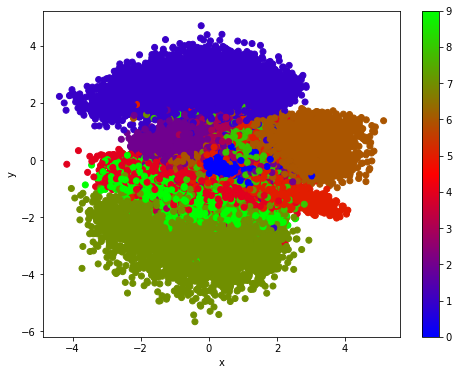

In [34]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2 and dataset == "MNIST":
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")